# Gaussian Processes

Gaussian Processes (GPs) are stochastic processes, i.e. collections of random variables, such that every finite collection of random variables has a multivariate normal distribution. 
GPs can be interpreted as **distributions over functions** $f(x)$. In fact, whenever we observe a finite set of values $(f(x_1),\ldots,f(x_N))$, we assume they are jointly normally distributed with some mean $\mu(x)$ and covariance $\Sigma(x)$. Let

$$ f(x) \sim \mathcal{GP}\big(\mu(x), \Sigma(x)\big)$$

denote a Gaussian Process, where for any finite subset $\bar{x}=(x_1,\ldots,x_N)$, the marginal distribution is a multivariate Gaussian $ f(\bar{x})\sim \mathcal{N}\big(\mu(\bar{x}), \Sigma(\bar{x})\big).$

## Kernels

The covariance matrix $\Sigma(x)$ of a GP is defined by a **kernel function** $k$, to ensure that the learned function preserves similarity between the inputs:

$$
\Sigma_{ij}=k(x_i,x_j).
$$


A kernel (or covariance function) $k:\mathcal{X}\times\mathcal{X}\rightarrow \mathbb{R}$ defines the statistical relationship between two variables in a space $\mathcal{X}$. It is symmetric and non-negative 

\begin{align*}
k(x,x')&=k(x',x)\\
k(x,x')&\geq0
\end{align*}

so it acts as a measure of similarity in $\mathcal{X}$ and the resulting matrix $\Sigma(x)$ is always symmetric and positive definite.

The choice of a specific kernel function allows to set a prior distribution over functions. Examples of valid kernels are the **radial basis function** (RBF) kernel

$$
k(x,x')=\sigma^2 \exp \Bigg(-\frac{||x-x'||^2}{2 l^2}\Bigg),
$$

the **polynomial** kernel 

$$
k(x,x')=\sigma^2 (x^T x'+b)^d
$$

and the **periodic** kernel 

$$ k(x,x')=\sigma^2 \exp\Bigg( -\frac{2 \sin^2 (\pi (x-x')/p)}{l^2} \Bigg).
$$

Let's define them in pyro using $\sigma=1, l=1, b=0.5, p=3$.

In [1]:
import torch
import numpy as np 

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.infer import MCMC, HMC, NUTS

from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process as gp_sklearn

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [14]:
# Define different types of kernels for Gaussian Processes using Pyro

# Radial Basis Function (RBF) kernel: commonly used for smooth functions
# 'input_dim=1' indicates the kernel is applied to one-dimensional input data
# 'variance' controls the vertical scale of the kernel's output
# 'lengthscale' controls how quickly the function's value changes over the input space (smoothness of the function)
# Here, lengthscale is set to 1, meaning the function is fairly smooth
rbf = gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.),
                     lengthscale=torch.tensor(2.)) 

# Polynomial kernel: a flexible kernel for modeling polynomial-like relationships
# Similar to the RBF kernel, but it includes a 'bias' term for additional flexibility
# The 'variance' controls the overall scale, and the 'bias' term allows for shifts in the function
polynomial = gp.kernels.Polynomial(input_dim=1, variance=torch.tensor(1.), bias=torch.tensor(.5))

# Periodic kernel: used for modeling functions that repeat periodically
# This kernel has three parameters: 
# - 'variance' controls the amplitude of the periodic function
# - 'lengthscale' determines how quickly the function's behavior changes over input space
# - 'period' defines the length of the cycle (e.g., how often the function repeats)
# In this case, the period is set to 3, meaning the function repeats every 3 units of input
periodic = gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.),
                               period=torch.tensor(3))  # <-- period set to 3 units


Let's now consider 50 equispaced test points in $[-5,5]$. We plot the covariance matrix of each kernel (first column) and take three samples from the multivariate normal distributions on the test points (second column). Notice that $\mu(x)=0$.

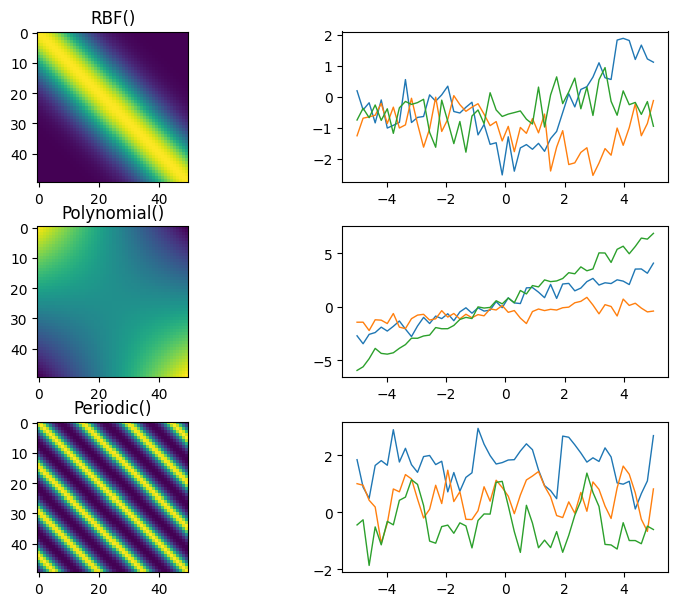

In [15]:
# Create a 3x2 grid of subplots for displaying the kernel covariance matrices and samples
fig, ax = plt.subplots(3, 2, figsize=(8, 6))  # Create a figure with 3 rows and 2 columns of subplots
fig.tight_layout()  # Adjust spacing between subplots

# Define the number of test points (points where the kernel will be evaluated)
n_test_points = 50
x_test = torch.linspace(-5, 5, n_test_points)  # Generate test points between -5 and 5

n_samples = 3  # Number of samples to draw from the prior

# Loop through each kernel: RBF, Polynomial, and Periodic
for row, kernel in enumerate([rbf, polynomial, periodic]):

    # Plot the covariance matrix of the kernel for the test points
    # 'kernel.forward(x_test, x_test)' computes the covariance between test points
    ax[row, 0].imshow(kernel.forward(x_test, x_test).detach().numpy(), cmap='viridis')
    ax[row, 0].set_title(str(kernel), fontsize=12)  # Set title to the kernel's name

    # Sampling from the prior distribution (mean = 0, covariance = K)
    mu = torch.zeros(n_test_points)  # Mean vector (assumed zero for the prior)
    # Compute the covariance matrix K for the test points, add small noise (0.4^2) to make it non-singular
    K = kernel.forward(x_test, x_test) + (0.4 ** 2) * torch.eye(len(x_test))
    
    # Generate samples from a multivariate normal distribution with mean 'mu' and covariance 'K'
    samples = dist.MultivariateNormal(mu, K).sample((n_samples,))

    # Plot the samples on the second column for each kernel
    for i, sample in enumerate(samples.detach().numpy()):
        ax[row, 1].plot(x_test, sample, lw=1)  # Plot each sample as a line

# Show the figure with the subplots
fig.show()


Kernel functions can also be combined together to generate more complex kernels, by using a set of suitable operations that preserve kernel properties [2, p.296].
For example, we can use products and linear combinations of kernels. 

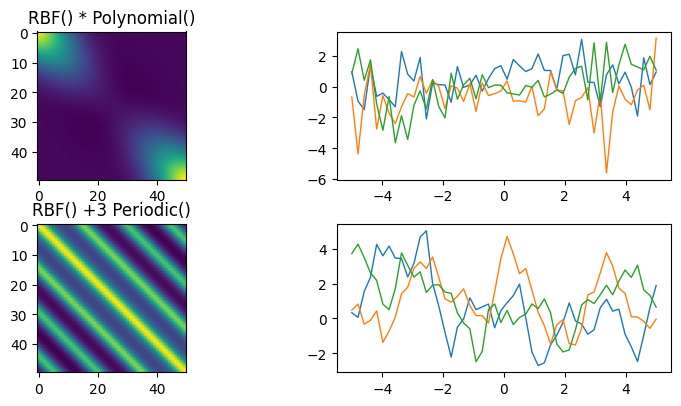

In [16]:
# Create a 2x2 grid of subplots to visualize covariance matrices and samples
fig, ax = plt.subplots(2, 2, figsize=(8, 4))  # 2 rows, 2 columns
fig.tight_layout()  # Adjust the spacing between subplots

### RBF * Polynomial ###
# First combination of kernels: RBF multiplied by Polynomial

# Covariance matrix: We compute the element-wise product of the covariance matrices of the RBF and Polynomial kernels
# This combines the two kernels multiplicatively to produce a new covariance matrix
ax[0, 0].imshow((rbf.forward(x_test, x_test) * polynomial.forward(x_test, x_test)).detach().numpy(), cmap='viridis')
ax[0, 0].set_title(str(rbf) + " * " + str(polynomial), fontsize=12)  # Title with kernel names

# Sampling from the prior: We calculate the new covariance matrix for the combined kernels (RBF * Polynomial)
K = rbf.forward(x_test, x_test) + (0.4**2) * torch.eye(len(x_test)) * \
    polynomial.forward(x_test, x_test) + (0.4**2) * torch.eye(len(x_test))  # Add noise to the covariance
samples = dist.MultivariateNormal(mu, K).sample((n_samples,))  # Draw samples from the multivariate normal distribution

# Plot each of the sampled functions in the second column
for i, sample in enumerate(samples.detach().numpy()):
    ax[0, 1].plot(x_test, sample, lw=1)  # Plot each sample as a line

### RBF + 3 * Periodic ###
# Second combination of kernels: RBF plus 3 times the Periodic kernel

# Covariance matrix: We compute the sum of the covariance matrices of the RBF and scaled Periodic kernels
# This combines the two kernels additively (with the Periodic kernel scaled by a factor of 3)
ax[1, 0].imshow((rbf.forward(x_test, x_test) + 3 * periodic.forward(x_test, x_test)).detach().numpy(), cmap='viridis')
ax[1, 0].set_title(str(rbf) + " +3 " + str(periodic), fontsize=12)  # Title with kernel names

# Sampling from the prior: We calculate the new covariance matrix for the combined kernels (RBF + 3 * Periodic)
K = rbf.forward(x_test, x_test) + (0.4**2) * torch.eye(len(x_test)) + \
    3 * periodic.forward(x_test, x_test) + (0.4**2) * torch.eye(len(x_test))  # Add noise to the covariance
samples = dist.MultivariateNormal(mu, K).sample((n_samples,))  # Draw samples from the multivariate normal distribution

# Plot each of the sampled functions in the second column
for i, sample in enumerate(samples.detach().numpy()):
    ax[1, 1].plot(x_test, sample, lw=1)  # Plot each sample as a line

# Display the figure with the subplots
fig.show()


## GP regression

We want to model a dependent variable $y$ as a function of an independent variable $x$, using a set of observations $D=\{(x_i,y_i)\}_i$. 

Classical Bayesian regression fits a parametric function $f(\theta,\cdot)$ to the data, i.e. it infers a probability distribution $f(\theta|D)$. Rather than learning single point estimates of $\theta$, it places a prior over parameters and updates the distribution whenever new data points are observed.

GPs, instead, have a **non-parametric** approach that infers a distribution $p(f|D)$ over all possible functions $f$. 

### Noise-free observations

Consider a 1-dimensional GP with mean $\mu=\mathbf{0}$ and an RBF kernel with $\sigma=1$ and $l=0.2$.

Given a test set $X_*=x_1,\ldots,x_N$, we want to predict the outputs $f_*=(f(x_1),\ldots,f(x_N))$.
Before observing any training data, we can sample from the prior distribution on $X_*$

$$
f_*\sim\mathcal{N}(\mathbf{0},K_{**}),
$$

where $K_{**}=k(X_*, X_*)$.


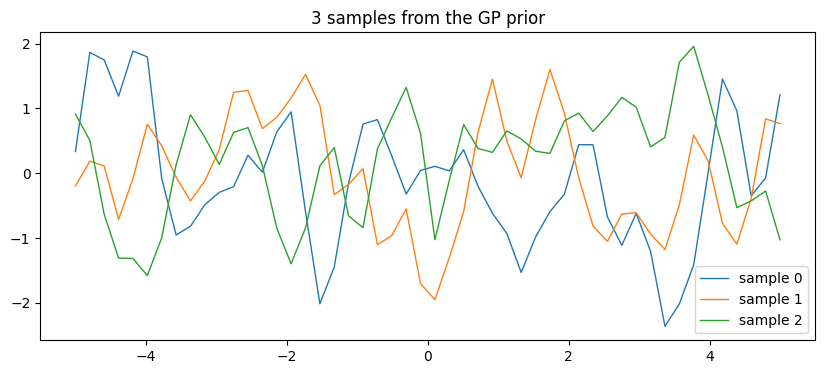

In [17]:
# Select 50 test points in the range from -5 to 5
n_test_points = 50
x_test = torch.linspace(-5, 5, n_test_points)  # Generate 50 test points from -5 to 5

# Set the prior distribution for the Gaussian Process
# Using the RBF kernel with 'variance' and 'lengthscale' set
kernel = gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(0.25))
mu = torch.zeros(n_test_points)  # Zero mean for the prior (assumed for simplicity)
K_ss = kernel.forward(x_test, x_test)  # Compute the covariance matrix for the test points

# Sample from the prior (Multivariate Normal distribution)
n_samples = 3  # Number of samples to draw from the prior
prior_samples = dist.MultivariateNormal(mu, K_ss).sample((n_samples,))  # Draw samples

# Plot the samples drawn from the GP prior
figsize = (10, 4)  # Set the figure size
plt.figure(figsize=figsize)  # Create the plot with the specified size
for i, sample in enumerate(prior_samples.detach().numpy()):
    # Plot each sample as a line
    plt.plot(x_test, sample, lw=1, label=f'sample {i}')

plt.title(f'{n_samples} samples from the GP prior')  # Add a title to the plot
plt.legend()  # Display the legend showing the sample number
plt.show()  # Display the plot


Suppose we observe a training set $X=\{(x_i, y_i)\}_i$, where the values of $y_i=f(x_i)$ are exact (i.e. non-noisy). The **joint distribution** on training and test points has the following form

$$
\binom{f}{f_*} \sim \mathcal{N} \Bigg(\binom{\mu}{\mu_*} , 
\begin{pmatrix} K & K_* \\ K_*^T & K_{**} \end{pmatrix}  \Bigg),
$$

where $K=k(X,X)$ and $K_*=k(X,X_*)$.


Now we can **condition on the training set** $X$ and obtain posterior mean and posterior covariance [1, p.517]

\begin{align*}
f_*|X_*,X,f &\sim \mathcal{N}(\mu_*,\Sigma_*)\\
\mu_* &= \mu(X_*) + K_*^T K^{-1} (f-\mu(X))\\
\Sigma_* &= K_{**}-K_*^T K^{-1} K_*.
\end{align*}


We now implement the posterior predictive distribution and plot a few posterior samples.

The training data consists of $4$ points $y=\sin(x)$ with $x\in\{-4,-2,1,4\}$.

In [18]:
def posterior_predictive(x_train, y_train, x_test, kernel, noise_var=None):
    """
    Compute the posterior predictive mean and covariance of a Gaussian Process model.
    
    Args:
    - x_train: Training input points (Tensor)
    - y_train: Training target values (Tensor)
    - x_test: Test input points (Tensor)
    - kernel: A kernel function for the GP (e.g., RBF, Polynomial)
    - noise_var: The noise variance, optional (if provided, it is added to the covariance matrix)
    
    Returns:
    - mu: The posterior mean (Tensor)
    - sigma: The posterior covariance (Tensor)
    """
    
    # Compute the covariance matrices
    # K: Covariance matrix for the training points
    K = kernel.forward(x_train, x_train)
    
    # K_s: Covariance matrix between training points and test points
    K_s = kernel.forward(x_train, x_test)
    
    # K_ss: Covariance matrix for the test points
    K_ss = kernel.forward(x_test, x_test)
    
    # If noise variance is provided, add the noise term to the training covariance matrix (diagonal)
    if noise_var is not None:
        K += (noise_var**2) * torch.eye(len(x_train))  # Add noise variance to the diagonal of K
    
    # Posterior mean: Using the standard GP formula for posterior mean
    mu = torch.mv(K_s.T, torch.mv(K.inverse(), y_train))  # mu = K_s.T * K^(-1) * y_train
    
    # Posterior covariance: Using the standard GP formula for posterior covariance
    sigma = K_ss - torch.mm(K_s.T, torch.mm(K.inverse(), K_s))  # sigma = K_ss - K_s.T * K^(-1) * K_s
    
    # Return the mean and covariance as 1D tensors
    return mu.reshape(-1), sigma


In [19]:
# Noiseless training data (x_train) and target values (y_train)
x_train = torch.FloatTensor([-4, -2, 1, 4])  # Input points (training data)
y_train = torch.sin(x_train)  # Target values (assumed to be a sine function for illustration)

# Compute the posterior predictive mean (mu) and covariance (sigma) for the test points
mu, sigma = posterior_predictive(x_train, y_train, x_test, kernel)  # Call the posterior_predictive function

# Symmetrize the covariance matrix to ensure it is positive definite
sigma = (sigma + sigma.T) / 2.0  # Make the covariance matrix symmetric (important for valid multivariate normal)

# Sample from the posterior distribution using Multivariate Normal
posterior_samples = dist.MultivariateNormal(mu, sigma).sample((n_samples,))  # Draw 'n_samples' samples from the posterior

# 'posterior_samples' now contains multiple realizations of the function (from the GP posterior).

In [21]:
def plot_posterior_distr(x_train, x_test, mu, sigma, posterior_samples=None, stdv_scale=2):
    """
    Plot the posterior distribution of a Gaussian Process.
    
    Arguments:
    - x_train: Training input points (Tensor or np.array)
    - x_test: Test input points (Tensor or np.array)
    - mu: Posterior mean (Tensor or np.array)
    - sigma: Posterior covariance (Tensor or np.array)
    - posterior_samples: Samples from the posterior (optional, Tensor or np.array)
    - stdv_scale: Scale factor for the standard deviation region (default 2)
    
    This function plots:
    - Training points as blue dots
    - Samples from the posterior as continuous lines
    - Posterior mean as a red dashed line
    - Standard deviation region (shaded)
    """
    plt.figure(figsize=(10, 6))  # Set the figure size

    # Detach tensors to convert them to numpy arrays (for plotting)
    x_train = x_train.detach().numpy() if isinstance(x_train, torch.Tensor) else x_train
    x_test = x_test.detach().numpy() if isinstance(x_test, torch.Tensor) else x_test
    mu = mu.detach().numpy() if isinstance(mu, torch.Tensor) else mu
    sigma = sigma.detach().numpy() if isinstance(sigma, torch.Tensor) else sigma

    # Plot the training points as blue dots
    plt.plot(x_train, y_train, 'bp', ms=8, label="Training points")
    
    # Plot posterior samples if available
    if posterior_samples is not None:
        plt.title(f'{len(posterior_samples)} samples from the GP posterior')
        
        # Plot each posterior sample as a continuous line
        for i, sample in enumerate(posterior_samples):
            plt.plot(x_test, sample, lw=1, label=f'Sample {i+1}')

    # Plot the posterior mean (red dashed line)
    plt.plot(x_test, mu, 'r--', lw=2, label="Posterior mean")
    
    # Plot the standard deviation region (shaded area around the mean)
    stdv = stdv_scale * np.sqrt(np.diag(sigma))  # Calculate the standard deviation
    plt.fill_between(x_test, mu - stdv, mu + stdv, alpha=0.1, color="red", label="± 2 stdv")

    # Show legend and plot
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Posterior Distribution with Samples and Uncertainty")
    plt.show()


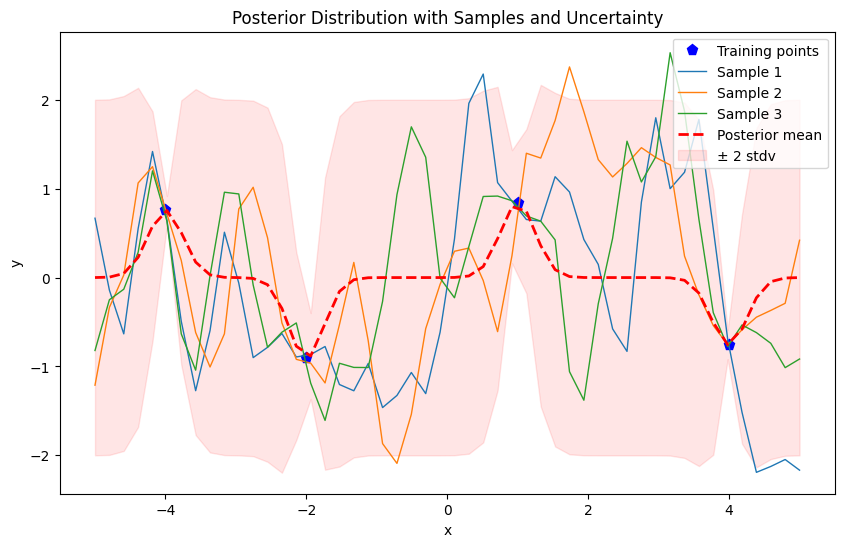

In [22]:
# Example usage (assuming you have the necessary variables defined like mu, sigma, and x_train):
plot_posterior_distr(x_train, x_test, mu, sigma, posterior_samples.detach().numpy())

Notice that since the observations are noiseless, the GP acts as an **interpolator** of the training data.


### Noisy observations

Now suppose that the observations are noisy 
$$y_i=f(x_i)+\epsilon \qquad \epsilon \sim\mathcal{N}(0, \sigma^2).$$

In this case, the model cannot interpolate the training points, but only get closer to them after conditing.

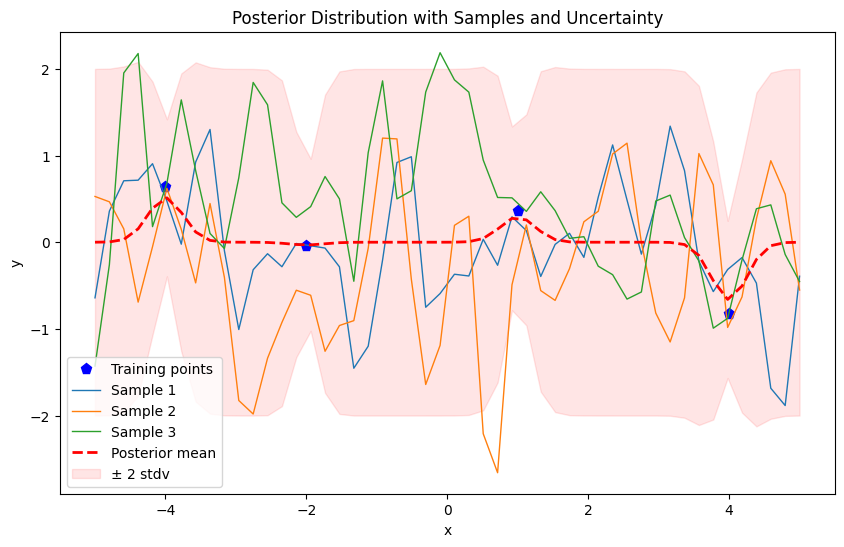

In [23]:
# Noisy Training Data Generation
noise_var = 0.5  # Define the variance of the noise. This controls the magnitude of the noise in the data.
noise = noise_var * dist.Normal(0, 1).sample((4,))  # Generate random noise samples from a Normal distribution with mean=0 and std=1.
y_train = torch.sin(x_train) + noise  # Add the generated noise to the sine function, creating noisy training data.

# Compute the Posterior Predictive (mean and covariance) for the Test Points
mu, sigma = posterior_predictive(x_train, y_train, x_test, kernel, noise_var) 
# Here, the posterior mean (mu) and covariance matrix (sigma) are calculated for the test points (x_test).
# The posterior mean gives the best estimate of the function at the test points.
# The covariance matrix represents the uncertainty of these estimates.

# Optional: Add jitter for numerical stability in case of small or ill-conditioned covariance matrices
# jitter = 1e-5 * torch.eye(sigma.shape[0], dtype=dtype, device=device) 
# sigma = sigma + jitter  # Jitter is added to the diagonal of the covariance matrix to ensure it's positive definite. 
# It's generally used to prevent problems with numerical inversion when computing the inverse of K.

# Ensure that the covariance matrix (sigma) is symmetric, as it should be for proper sampling.
sigma = (sigma + sigma.T) / 2.0  # The covariance matrix might have small numerical errors. This operation fixes that.

# Sampling from the Posterior Distribution
posterior_samples = dist.MultivariateNormal(mu, sigma).sample((n_samples,)) 
# We sample multiple (n_samples) possible functions from the posterior distribution.
# These samples represent possible realizations of the underlying function given the training data and kernel.

# Plotting the Posterior Distribution
# Visualize the posterior mean, posterior samples, and uncertainty (±2 standard deviations) in the predictions.

plot_posterior_distr(x_train, x_test, mu, sigma, posterior_samples.detach().numpy()) 
# This function call generates the plot showing:
# - The training data points as blue dots.
# - The posterior mean as a red dashed line.
# - The uncertainty range (±2 standard deviations) as a shaded area around the mean.
# - The posterior samples as continuous lines, showing potential realizations of the underlying function.



By changing the kernel hyperparameters we could obtain a significantly different fit to the data.

kernel_var=0.3, kernel_ls=0.2, noise_var=0.5


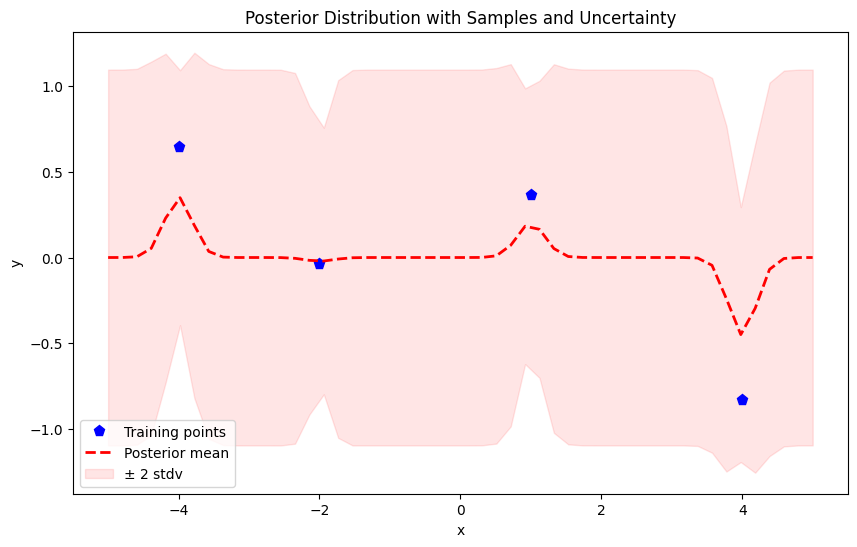

kernel_var=1.0, kernel_ls=0.5, noise_var=0.5


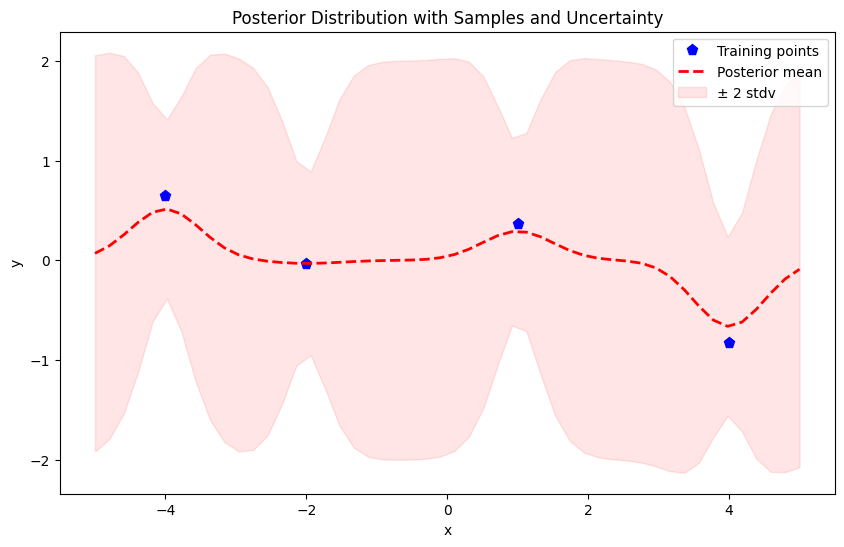

In [24]:
# List of different kernel hyperparameters (variance, lengthscale)
params = [(0.3, 0.2), (1., 0.5)]  # Each tuple contains (kernel variance, kernel lengthscale)

# Loop over the list of kernel parameters
for kernel_var, kernel_ls in params:
    # Define the kernel with the current parameters (variance and lengthscale)
    kernel = gp.kernels.RBF(input_dim=1, variance=torch.tensor(kernel_var), lengthscale=torch.tensor(kernel_ls))

    # Compute the posterior predictive distribution (mean and covariance) using the current kernel
    mu, sigma = posterior_predictive(x_train, y_train, x_test, kernel, noise_var)
    
    # Print the current parameters being used for the kernel
    print(f"kernel_var={kernel_var}, kernel_ls={kernel_ls}, noise_var={noise_var}")

    # Plot the posterior distribution (mean, samples, and uncertainty)
    plot_posterior_distr(x_train, x_test, mu, sigma)


## Learn kernel parameters 

Instead of arbitrarily choosing the kernel hyperparameters, we could infer them directly from the observed data.

### Scikit-learn MLE

`GaussianProcessRegressor` from scikit-learn library optimizes the kernel hyperparameters $\theta$ by maximizing the marginal log-likelihood $ p(y| x,\theta)$ on the observed data $(x,y)$

$$
\hat{\theta} = \text{argmax}_\theta p(y| x,\theta).
$$

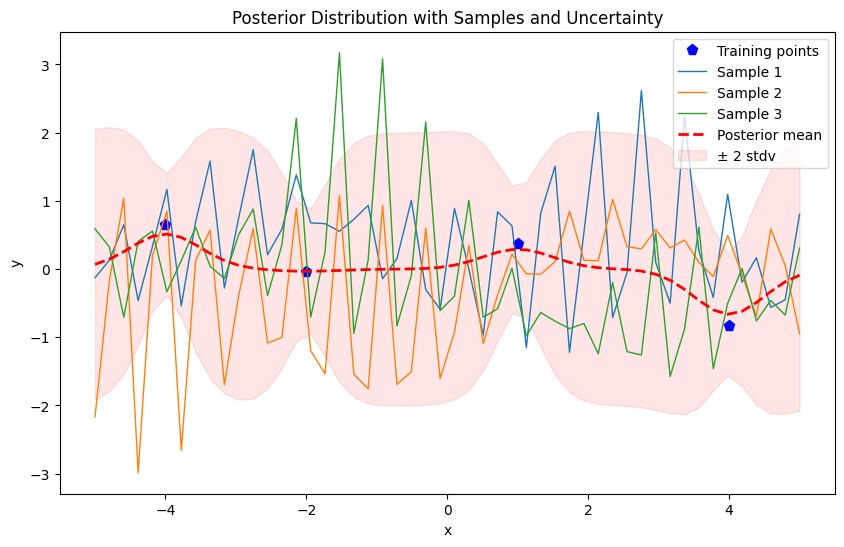

In [25]:
# Set kernel and GP model
kernel_sklearn = gp_sklearn.kernels.RBF(length_scale=1.0)  # Define the RBF kernel with length scale of 1.0
gpr_sklearn = GaussianProcessRegressor(kernel_sklearn)  # Initialize a GaussianProcessRegressor with the defined kernel

# Fit the GP model to the observed training data
gpr_sklearn.fit(x_train.reshape(-1, 1), y_train.reshape(-1, 1)) 
# Reshape the training data (x_train, y_train) into the correct format required by sklearn (n_samples, n_features)
# The GP model is then trained (fitted) on the provided data to learn the underlying function.

# Sample from the posterior distribution
posterior_samples = gpr_sklearn.sample_y(x_test.reshape(-1, 1), n_samples=n_samples)
# Sample multiple (n_samples) realizations of the function from the posterior distribution at the test points (x_test)
# The resulting posterior_samples is an array of size (n_samples, len(x_test)) containing the sampled functions.

# Reshape the samples to match the expected shape
posterior_samples = posterior_samples.reshape(n_samples, len(x_test))

# Plot the posterior distribution: mean, uncertainty, and posterior samples
plot_posterior_distr(x_train, x_test, mu, sigma, posterior_samples)
# This function plots:
# - The training points (x_train, y_train)
# - The posterior mean (red dashed line)
# - The uncertainty (shaded area representing ±2 standard deviations)
# - The posterior samples (multiple lines representing different possible realizations of the function)


### Pyro HMC inference

Pyro `gp.models.GPRegression` class allows to perform approximate inference on the kernel parameters.  Let's look at an example with HMC algorithm.

In [26]:
# Import necessary libraries
import torch
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, HMC
import math

# Synthetic data creation
x_train = x_train.unsqueeze(-1)  # Reshape x_train to be of shape (N, 1), where N is the number of data points
y_train = torch.sin(x_train).squeeze()  # Generate y_train by applying a sine function to x_train (target values)
noise_var = 1e-2  # Set noise variance for the model (a small value to account for observational noise)

# Custom GP model compatible with MCMC
def model(x, y):
    n = x.size(0)  # Get the number of data points (N)

    # Priors on kernel hyperparameters (using LogNormal distributions for these hyperparameters)
    # These priors represent the uncertainty in the values of the hyperparameters before observing the data
    lengthscale = pyro.sample("lengthscale", dist.LogNormal(0., 0.5))  # Lengthscale prior
    variance = pyro.sample("variance", dist.LogNormal(0., 0.5))  # Variance prior
    noise = pyro.sample("noise", dist.LogNormal(-5., 0.1))  # Observational noise prior

    # RBF (squared exponential) kernel - defining the covariance function
    diff = x.unsqueeze(1) - x.unsqueeze(0)  # Compute the pairwise distances between points in x
    K = variance * torch.exp(-0.5 * (diff ** 2).sum(-1) / lengthscale**2)  # Compute the RBF kernel matrix
    K += noise * torch.eye(n)  # Add observational noise (diagonal jitter to the covariance matrix)

    # Likelihood function for the observed data: y ~ MultivariateNormal(0, K)
    # This defines how likely the observed data is, given the kernel and noise
    pyro.sample("y", dist.MultivariateNormal(torch.zeros(n), covariance_matrix=K), obs=y.squeeze())

# Initialize HMC kernel (Hamiltonian Monte Carlo)
hmc_kernel = HMC(model)  # Set up the HMC kernel with the defined GP model
mcmc = MCMC(hmc_kernel, num_samples=30, warmup_steps=200)  # Create the MCMC object with 30 samples and 200 warmup steps

# Run MCMC (Markov Chain Monte Carlo) for inference
pyro.clear_param_store()  # Clear any previous parameter stores in Pyro (important for multiple runs)
mcmc.run(x_train, y_train)  # Run MCMC on the data: samples the posterior distribution for the kernel parameters



Sample: 100%|██████████| 230/230 [00:28,  8.14it/s, step size=7.06e-01, acc. prob=0.948]


Now we sample from the posterior distribution, using the learned parameters. 

In [84]:
# Get posterior samples from the MCMC run
posterior_samples = mcmc.get_samples()

# Compute the posterior mean of the kernel hyperparameters
# The 'variance' and 'lengthscale' are parameters from the RBF kernel that we sampled during MCMC

kernel_var = posterior_samples['variance'].mean()  # Compute the mean of the posterior samples for variance
kernel_ls = posterior_samples['lengthscale'].mean()  # Compute the mean of the posterior samples for lengthscale

# Print the posterior mean of the kernel hyperparameters
print("Posterior mean of variance:", kernel_var.item())  # Print the posterior mean of variance
print("Posterior mean of lengthscale:", kernel_ls.item())  # Print the posterior mean of lengthscale

Posterior mean of variance: 1.0200434923171997
Posterior mean of lengthscale: 0.9019509553909302


In [86]:
from pyro.contrib.gp.kernels import RBF  # Importing the Radial Basis Function (RBF) kernel from Pyro
from pyro.contrib.gp import models, kernels  # Importing GP regression models and kernel functions

# Create the RBF kernel with posterior parameters
# Using the posterior mean of the variance and lengthscale as kernel hyperparameters
kernel = kernels.RBF(input_dim=1, variance=kernel_var, lengthscale=kernel_ls)
# This creates an RBF kernel that will define the covariance function for the GP

# Create the GP regression model
# We use the RBF kernel in the GP regression model along with the training data (x_train and y_train)
gpr = models.GPRegression(x_train, y_train, kernel=kernel, noise=torch.tensor(noise_var))
# The noise term is added to account for the uncertainty or errors in the observations

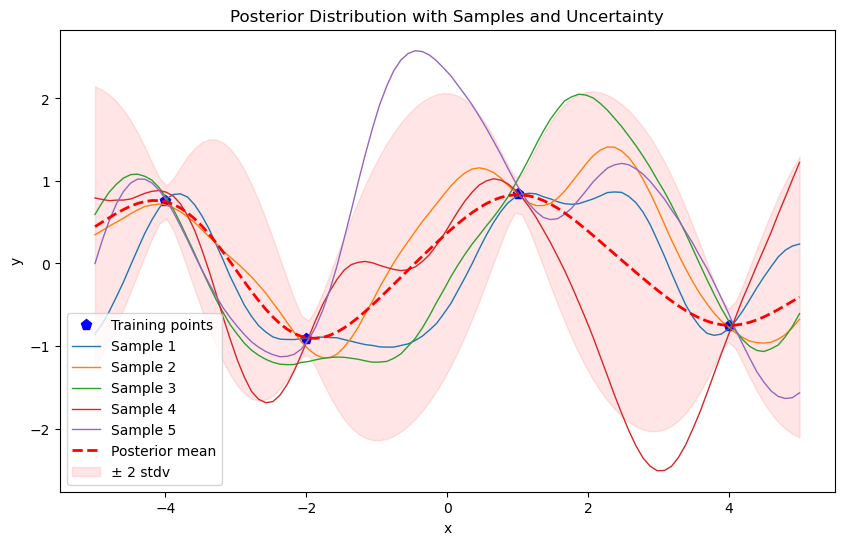

In [87]:
# Test points (linspace between -5 and 5)
n_test_points = 100  # Set the number of test points (can be any other value)
# Create a tensor of test points between -5 and 5
x_test = torch.linspace(-5, 5, n_test_points).unsqueeze(-1)  # Add an extra dimension for the model

# Calculate prediction: mean and covariance
# The `forward` method of the Gaussian Process model computes the posterior mean (mu) and covariance (sigma)
# for the test points (x_test). The `full_cov=True` argument ensures the full covariance matrix is computed.
mu, sigma = gpr.forward(x_test, full_cov=True)  # Compute the mean and covariance for the test points

# Symmetrize the covariance matrix to ensure it is positive definite
sigma = (sigma + sigma.T) / 2.0  # Ensure symmetry (sometimes numerical issues can result in an asymmetric covariance matrix)

# Add jitter to the covariance matrix for numerical stability
# A small jitter term helps avoid numerical issues, especially if the matrix is close to singular.
jitter = 1e-5 * torch.eye(sigma.shape[0])  # Jitter is a small value added to the diagonal
sigma = sigma + jitter  # Add the jitter to the covariance matrix

# Sample from the posterior distribution
# Here, we sample from a multivariate normal distribution with the mean `mu` and covariance `sigma`
n_samples = 5  # Number of samples to draw
posterior_samples = dist.MultivariateNormal(mu, sigma).sample((n_samples,))  # Draw n_samples from the posterior

# Plot the posterior distribution
plot_posterior_distr(x_train.flatten(), x_test.flatten(), mu, sigma, posterior_samples)


## References
[1] K. P. Murphy, "Machine Learning: A Probabilistic Perspective", Chap. 15

[2] C. M. Bishop, "Pattern Recognition and Machine Learning", Chap. 6

[3] [Pyro GPs documentation](https://pyro.ai/examples/gp.html)

[4] [SKlearn GPs documentation](https://scikit-learn.org/stable/modules/gaussian_process.html)

[5] [GPyTorch library](https://gpytorch.ai/)